# 🏃🧠 3. Machine Learning models for Cardiorespiratory Fitness Estimation

*Master in Data Science and Big Data*

*Author: Marcos Jiménez Juliana*

*Master's Thesis*

<a id = id_0><a/>

# Index

1. [Importing Data from PostgreSQL Datawarehouse](#part_1)
2. [Data Pre-Processing](#prepro)
   1. [Removing Useless Variables](#useless)
   2. [One-Hot Encoding of Categorical Variables](#ohe)
   3. [Feature Transformation and Normalization](#normalization)
3. [Machine Learning Models](#models)
   1. [Splitting the Dataset](#split)
   2. [Feature Scaling](#scaling)
   3. [Multiple Linnear Regression](#mlr)
      1. [Coarse-to-Fine Hyperparameter Tuning Search](#mlr_1)
      2. [Model Training](#mlr_2)
      3. [Model Evaluation](#mlr_3)
   4. [Bagging - Random Forest](#rf)
      1. [Coarse-to-Fine Hyperparameter Tuning Search](#rf_1)
      2. [Model Training](#rf_2)
      3. [Model Evaluation](#rf_3)
   5. [Boosting -XGboost](#xgb)
      1. [Coarse-to-Fine Hyperparameter Tuning Search](#xgb_1)
      2. [Model Training](#xgb_2)
      3. [Model Evaluation](#xgb_3)
4. [Feature Importance](#overall)
5. [Saving the Best Model](#saving)

<a id = part_1><a/>
## 1. Importing Data from PostgreSQL Data Warehouse

In [51]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The src folder is added to Python's search path
sys.path.append(os.path.abspath("../src"))

# My functions
import etl

First of all, the data previously stored in the DataWarehouse NHANES database in the table called `biometrics` is imported using Python's `SQLAlchemy` library. 

In [53]:
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine

# This earch for the nearest .env upwards in the folder tree
load_dotenv(find_dotenv())

# Retreive your credentials
user=os.getenv("DB_USER")
password=os.getenv("DB_PASSWORD")
host=os.getenv("DB_HOST")
port=os.getenv("DB_PORT")
database=os.getenv("DB_NAME")

# SQL Alchemy engine
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# SQL Query 
sql = "SELECT * FROM biometrics;"

# storing the data into a pandas df
df = pd.read_sql_query(sql, engine)
df.head()

,id,cohort,age,gender,ethnic_group,poverty_ratio,family_income,education_level,health_insurance,smoker,...,weight_diff,weight,height,cholesterol,red_blood_cell_count,hemoglobin,hematocrit,mean_cell_hemoglobin,red_cell_distribution_width,vo2max
0,5.0,1.0,49.0,1.0,3.0,5.00,11,2,1,yes,...,6.350301,92.5,178.3,279.0,5.13,14.5,43.6,28.3,13.1,40.03
1,6.0,1.0,19.0,0.0,5.0,1.21,3,2,1,former,...,7.711079,59.2,162.0,153.0,4.22,13.1,38.7,30.9,12.8,35.48
2,11.0,1.0,15.0,1.0,3.0,1.25,6,0,1,former,...,0.000000,65.0,171.9,132.0,5.55,16.3,48.3,29.4,11.8,58.85
3,15.0,1.0,38.0,0.0,3.0,4.52,8,2,1,yes,...,4.535929,81.6,174.9,199.0,4.14,13.3,40.2,32.1,11.9,37.60
4,21.0,1.0,18.0,1.0,1.0,1.80,6,1,0,no,...,-11.339823,112.9,168.5,161.0,5.36,16.4,46.8,30.6,12.5,37.36


- Alternatively, the data can be obtained from the cleaned `biometrics.csv` file in the repository:

In [3]:
# Uncomment if neccesary
#df = pd.read_csv('../data/processed/biometrics.csv')
#df.head()

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8324 entries, 0 to 8323
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           8324 non-null   float64
 1   cohort                       8324 non-null   float64
 2   age                          8324 non-null   float64
 3   gender                       8324 non-null   float64
 4   ethnic_group                 8324 non-null   float64
 5   poverty_ratio                8324 non-null   float64
 6   family_income                8324 non-null   int64  
 7   education_level              8324 non-null   int64  
 8   health_insurance             8324 non-null   int64  
 9   smoker                       8324 non-null   object 
 10  physical_activity_time       8324 non-null   float64
 11  systolic_bp                  8324 non-null   float64
 12  diastolic_bp                 8324 non-null   float64
 13  pulse_rate        

-------------------------
<a id = prepro><a/>

[Go to index](#id_0)

## 2. Data Pre-processing
<a id = useless><a/>
### 2.1. Removing Useless Variables

In [55]:
df = df.drop(columns = ['id', 'cohort'], axis = 1)

In [56]:
df.columns

Index(['age', 'gender', 'ethnic_group', 'poverty_ratio', 'family_income',
       'education_level', 'health_insurance', 'smoker',
       'physical_activity_time', 'systolic_bp', 'diastolic_bp', 'pulse_rate',
       'bmi', 'waist_perimeter', 'body_fat_percent', 'weight_diff', 'weight',
       'height', 'cholesterol', 'red_blood_cell_count', 'hemoglobin',
       'hematocrit', 'mean_cell_hemoglobin', 'red_cell_distribution_width',
       'vo2max'],
      dtype='object')



<a id = ohe><a/>

[Go to index](#id_0)

### 2.2. One-Hot Encoding of Categorical Variables

In [57]:
df = pd.get_dummies(df,
                      columns = ['ethnic_group','smoker'],
                      dtype= float
                     )
df = df.rename({
    'ethnic_group_1.0': 'ethnic_mexican',
    'ethnic_group_2.0': 'ethnic_hispanic',
    'ethnic_group_3.0': 'ethnic_white',
    'ethnic_group_4.0': 'ethnic_black',
    'ethnic_group_5.0': 'ethnic_other'
}, axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8324 entries, 0 to 8323
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          8324 non-null   float64
 1   gender                       8324 non-null   float64
 2   poverty_ratio                8324 non-null   float64
 3   family_income                8324 non-null   int64  
 4   education_level              8324 non-null   int64  
 5   health_insurance             8324 non-null   int64  
 6   physical_activity_time       8324 non-null   float64
 7   systolic_bp                  8324 non-null   float64
 8   diastolic_bp                 8324 non-null   float64
 9   pulse_rate                   8324 non-null   float64
 10  bmi                          8324 non-null   float64
 11  waist_perimeter              8324 non-null   float64
 12  body_fat_percent             8324 non-null   float64
 13  weight_diff       

In [58]:
etl.descriptors(df)

,count,mean,std,min,25%,50%,75%,max,unique_values,null_values
age,8324.0,22.456151,10.385105,1.200000e+01,15.000,18.000,29.000000,49.000000,38,0
gender,8324.0,0.517900,0.499710,0.000000e+00,0.000,1.000,1.000000,1.000000,2,0
poverty_ratio,8324.0,2.320385,1.559402,5.397605e-79,1.020,1.940,3.540000,5.000000,967,0
family_income,8324.0,6.423715,3.057198,1.000000e+00,4.000,6.000,9.000000,11.000000,11,0
education_level,8324.0,0.626141,0.846685,0.000000e+00,0.000,0.000,1.000000,2.000000,3,0
health_insurance,8324.0,0.753844,0.430796,0.000000e+00,1.000,1.000,1.000000,1.000000,2,0
physical_activity_time,8324.0,3078.455286,3970.569434,0.000000e+00,780.000,1846.000,3780.000000,54600.000000,2772,0
systolic_bp,8324.0,113.101442,11.488572,7.200000e+01,106.000,112.000,120.000000,196.000000,112,0
diastolic_bp,8324.0,64.845699,12.174794,5.397605e-79,58.000,66.000,72.000000,108.000000,120,0
pulse_rate,8324.0,72.960356,11.115803,3.800000e+01,64.000,72.000,80.000000,100.000000,32,0



<a id = normalization><a/>

[Go to index](#id_0)

### 2.3. Feature Transformation and Normalization

In [59]:
from sklearn.preprocessing import StandardScaler

columnas = ['age', 'family_income', 'education_level', 'poverty_ratio', 'physical_activity_time',
       'systolic_bp', 'diastolic_bp', 'pulse_rate', 'bmi', 'waist_perimeter', 'body_fat_percent',
       'weight', 'height', 'cholesterol', 'weight_diff','red_blood_cell_count','hemoglobin','hematocrit','mean_cell_hemoglobin','red_cell_distribution_width',  'vo2max']

scaler = StandardScaler()

df_scaled = df.copy()
df_scaled[columnas] = pd.DataFrame(scaler.fit_transform(df[columnas]), columns =columnas)

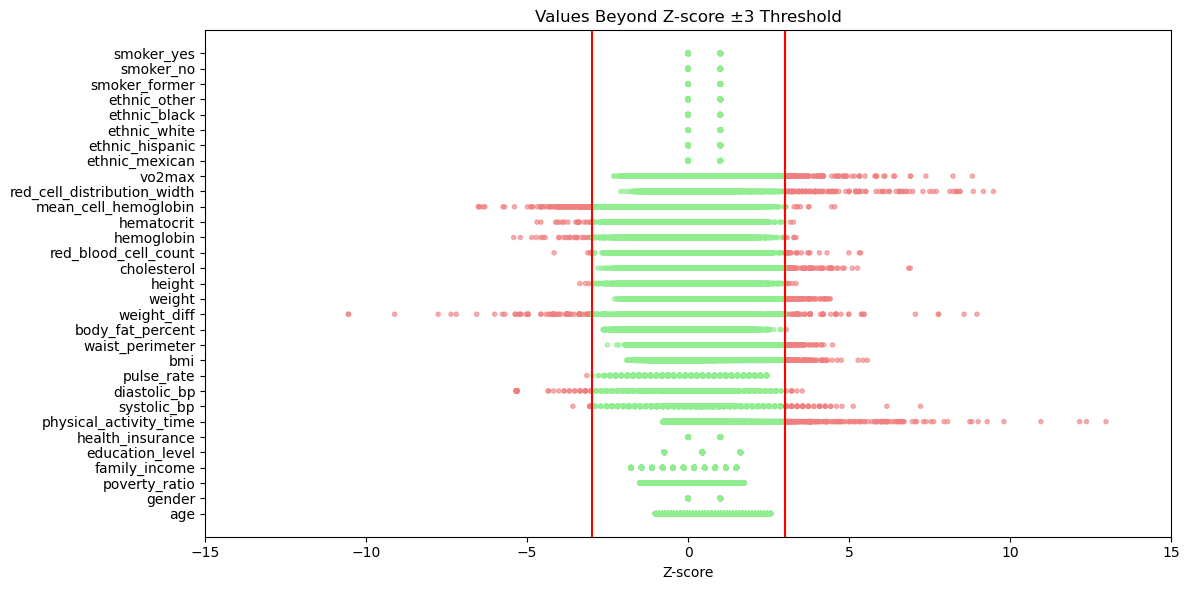

In [10]:
plt.figure(figsize=(12, 6)) 


for i, col in enumerate(df_scaled.columns):
    values = df_scaled[col]
    
    # Assign a color based on whether the standardized value is within ±3
    colors = ['lightgreen' if -3 <= val <= 3 else 'lightcoral' for val in values]
    
    # plot
    plt.scatter(values, [i]*len(values), color=colors, alpha=0.6, marker='.')

# Formatting
plt.yticks(range(len(df_scaled.columns)), df_scaled.columns)
plt.xlim(-15, 15)
plt.axvline(-3, color='red', linestyle='-')
plt.axvline(3, color='red', linestyle='-')
plt.title("Values Beyond Z-score ±3 Threshold")
plt.xlabel("Z-score")

plt.tight_layout()
#plt.savefig('zscore_1.png', dpi = 400)
plt.show() 

**FEATURE TRANSFORMATION**

In [60]:
# Logarithmic transformations (log1p used for variables that may contain zeros)
df['physical_activity_time'] = np.log1p(df['physical_activity_time'])
df['poverty_ratio'] = np.log1p(df['poverty_ratio'])

# Standard logarithmic transformations
df['bmi'] = np.log(df['bmi'])
df['waist_perimeter'] = np.log(df['waist_perimeter'])
df['weight'] = np.log(df['weight'])
df['cholesterol'] = np.log(df['cholesterol'])
df['vo2max'] = np.log(df['vo2max'])

# Symmetric square root transformation for variables with both positive and negative values
df['weight_diff'] = np.sign(df['weight_diff']) * np.sqrt(np.abs(df['weight_diff']))

In [12]:
columnas = ['age', 'family_income', 'education_level', 'poverty_ratio', 'physical_activity_time',
       'systolic_bp', 'diastolic_bp', 'pulse_rate', 'bmi', 'waist_perimeter', 'body_fat_percent',
       'weight', 'height', 'cholesterol', 'weight_diff','red_blood_cell_count','hemoglobin','hematocrit','mean_cell_hemoglobin','red_cell_distribution_width',  'vo2max']

scaler = StandardScaler()

df_scaled_2 = df.copy()
df_scaled_2[columnas] = pd.DataFrame(scaler.fit_transform(df[columnas]), columns =columnas)

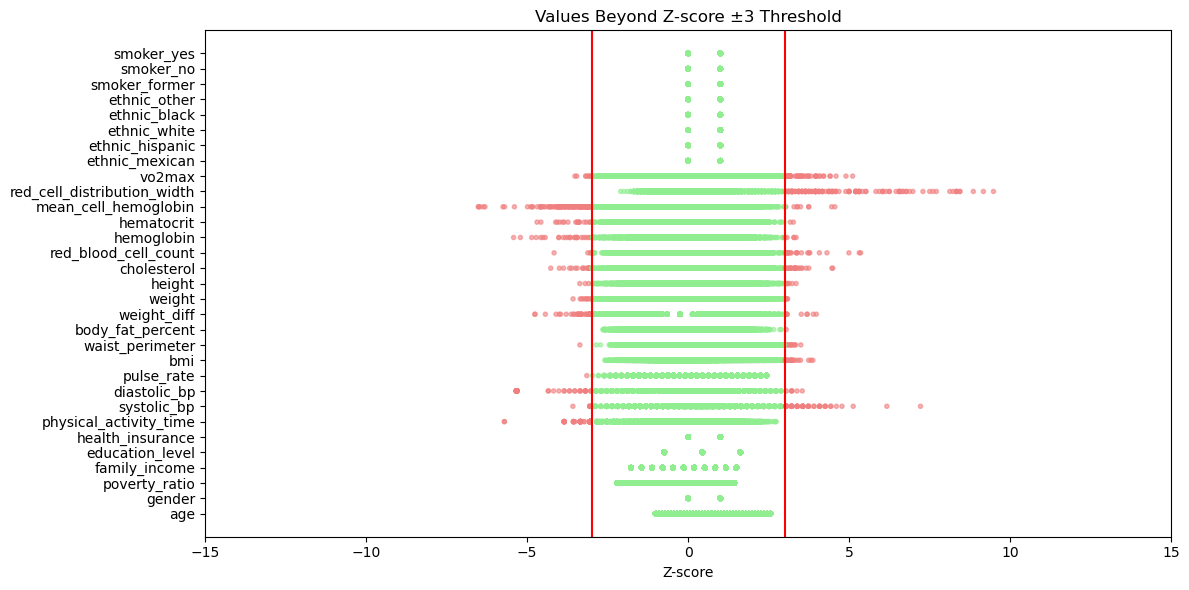

In [13]:
plt.figure(figsize=(12, 6)) 


for i, col in enumerate(df_scaled_2.columns):
    values = df_scaled_2[col]
    
    # Assign a color based on whether the standardized value is within ±3
    colors = ['lightgreen' if -3 <= val <= 3 else 'lightcoral' for val in values]
    
    # Use scatter plot to display each value, coloring individually
    plt.scatter(values, [i]*len(values), color=colors, alpha=0.6, marker='.')

# Formatting
plt.yticks(range(len(df_scaled_2.columns)), df_scaled_2.columns)
plt.xlim(-15, 15)
plt.axvline(-3, color='red', linestyle='-')
plt.axvline(3, color='red', linestyle='-')
plt.title("Values Beyond Z-score ±3 Threshold")
plt.xlabel("Z-score")

plt.tight_layout()
#plt.savefig('zscore_2.png', dpi = 400)
plt.show() 

-------------------------
<a id = models><a/>

[Go to index](#id_0)

## 3. Machine Learning Models

In [14]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold

# Evaluation
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

<a id = split><a/>

[Go to index](#id_0)

### 3.1. Splitting the Dataset

The dataset is not scaled before the train-test split to avoid data leakage; scaling will be applied only on the training data and then used on the test data.

In [61]:
# Splitting into explanatory variables (X) and target variable VO2Max (y)
X = df.drop('vo2max', axis=1)
y = df['vo2max']

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# Check of the datasets size
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (6659, 30)
y_train shape: (6659,)
X_test shape: (1665, 30)
y_test shape: (1665,)



<a id = scaling><a/>

[Go to index](#id_0)

### 3.2. Feature Scaling

In [62]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the splitted data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check 
print(f"X_train_scaled mean (approx.):{X_train_scaled.mean().round(2)}")
print(f"X_train_scaled std (approx.):{X_train_scaled.std().round(2)}")

X_train_scaled mean (approx.):0.0
X_train_scaled std (approx.):1.0


> As observed, after standardization, the data mean is approximately 0 and the standard deviation is 1.

-------------------------
<a id = mlr><a/>

[Go to index](#id_0)

### 3.3. Multiple Linnear Regression

<a id = mlr_1><a/>

#### 3.3.1. Coarse-to-Fine Hyperparameter Tuning Search

In [17]:
# Multiple Linear Regression model is defined
mlr = LinearRegression()


# Parameter grid for search
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# K-Fold cross-validation strategy for regression
kf = KFold(n_splits = 5, shuffle=True, random_state=123)

# GridSearchCV 
search = GridSearchCV(
    estimator=mlr,
    param_grid=param_grid,
    cv=kf,
    scoring="neg_mean_absolute_error",
    refit=True,
    n_jobs=-1
)
search.fit(X_train_scaled, y_train)

print("Best parameters from GridSearchCV (fine search):", search.best_params_)
print("Best estimator from GridSearchCV:", search.best_estimator_)

# Retrieve cross-validation results for all metrics
results = pd.DataFrame(search.cv_results_)
results.sort_values('rank_test_score', ascending = True)

Best parameters from GridSearchCV (fine search): {'fit_intercept': True, 'positive': False}
Best estimator from GridSearchCV: LinearRegression()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_positive,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.903600,0.021285,0.004578,0.001667,True,False,"{'fit_intercept': True, 'positive': False}",-0.148076,-0.143187,-0.153729,-0.148173,-0.141904,-0.147014,0.004203,1
0,1.649767,0.035895,0.001919,0.000056,True,True,"{'fit_intercept': True, 'positive': True}",-0.160839,-0.154018,-0.168739,-0.162496,-0.155016,-0.160222,0.005361,2
2,0.669524,0.778873,0.001500,0.000419,False,True,"{'fit_intercept': False, 'positive': True}",-3.714976,-3.709221,-3.708461,-3.709604,-3.700704,-3.708593,0.004570,3
3,1.093098,0.009796,0.004343,0.001704,False,False,"{'fit_intercept': False, 'positive': False}",-3.728723,-3.726559,-3.719945,-3.724883,-3.708019,-3.721626,0.007393,4


<a id = mlr_2><a/>

[Go to index](#id_0)

#### 3.3.2. Model Training

In [18]:
# Model training with the best estimator found
mlr_best = search.best_estimator_
mlr_best.fit(X_train_scaled, y_train)

LinearRegression()

In [19]:
print('Coeficients: ', mlr_best.coef_)
print('Intercept: ', mlr_best.intercept_)

Coeficients:  [-1.67279721e-02  4.49774363e-02 -1.44360941e-02  1.08101556e-02
 -8.70560063e-03  1.34839596e-03  8.78762871e-03 -3.34509017e-03
 -1.42905987e-05 -3.96932814e-02  1.49431168e-01 -1.86728337e-02
 -5.08339826e-02 -6.64792524e-03 -1.86373080e-01  9.25720423e-02
 -9.31371830e-03  8.52944456e-02 -6.25662810e-02 -2.13154053e-02
  6.21233917e-02 -8.09144533e-03  8.42650544e-03 -6.05641841e-04
 -1.53725765e-03 -5.78445413e-03 -2.77911832e-03 -2.01607649e-03
 -3.34854072e-03  6.21436546e-03]
Intercept:  3.7025882672566284


In [20]:
features = X.columns
coefs = pd.Series(mlr_best.coef_, index=features)
print("Model equation:")
equation = f"y = {mlr_best.intercept_:.3f} "
for feat, coef in coefs.items():
    equation += f"+ ({coef:.3f})*{feat} "
print(equation)

Model equation:
y = 3.703 + (-0.017)*age + (0.045)*gender + (-0.014)*poverty_ratio + (0.011)*family_income + (-0.009)*education_level + (0.001)*health_insurance + (0.009)*physical_activity_time + (-0.003)*systolic_bp + (-0.000)*diastolic_bp + (-0.040)*pulse_rate + (0.149)*bmi + (-0.019)*waist_perimeter + (-0.051)*body_fat_percent + (-0.007)*weight_diff + (-0.186)*weight + (0.093)*height + (-0.009)*cholesterol + (0.085)*red_blood_cell_count + (-0.063)*hemoglobin + (-0.021)*hematocrit + (0.062)*mean_cell_hemoglobin + (-0.008)*red_cell_distribution_width + (0.008)*ethnic_mexican + (-0.001)*ethnic_hispanic + (-0.002)*ethnic_white + (-0.006)*ethnic_black + (-0.003)*ethnic_other + (-0.002)*smoker_former + (-0.003)*smoker_no + (0.006)*smoker_yes 


<a id = mlr_3><a/>

[Go to index](#id_0)

#### 3.3.3. Model Evaluation

In [21]:
# Predictions on the test set
y_pred = mlr_best.predict(X_test_scaled)

# Compute evaluation metrics (MLR-specific)
mlr_r2 = r2_score(y_test, y_pred)
mlr_mse = mean_squared_error(y_test, y_pred)
mlr_rmse = mean_squared_error(y_test, y_pred) ** 0.5 
mlr_mae = mean_absolute_error(y_test, y_pred)
mlr_mape = mean_absolute_percentage_error(y_test, y_pred)

print("Test set evaluation metrics for MLR:")
print(f"MLR R²: {mlr_r2:.4f}")
print(f"MLR MSE: {mlr_mse:.4f}")
print(f"MLR RMSE: {mlr_rmse:.4f}")
print(f"MLR MAE: {mlr_mae:.4f}")
print(f"MLR MAPE: {mlr_mape:.4f}")

Test set evaluation metrics for MLR:
MLR R²: 0.2953
MLR MSE: 0.0378
MLR RMSE: 0.1944
MLR MAE: 0.1479
MLR MAPE: 0.0398


> **Note**: Although the metrics might seem low, it should be remembered that we are working with real-world and limited data. The best models reported in the literature to date achieve an R² of around 0.3. Furthermore, this is the baseline model; we will now proceed with the other models.

-------------------------
<a id = rf><a/>

[Go to index](#id_0)

### 3.4. Bagging -  Random Forest

<a id = rf_1><a/>

[Go to index](#id_0)

#### 3.4.1. Coarse-to-Fine Hyperparameter Tuning Search

In [22]:
# Define Random Forest model
rf = RandomForestRegressor(random_state=123)

# Coarse parameter grid
param_grid_rf_1 = {
    'n_estimators': [500, 700, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [5, 20, 40],
    'max_features': ['sqrt', 'log2', 0.8, 0.9]
}

# K-Fold cross-validation
kf_rf = KFold(n_splits=5, shuffle=True, random_state=123)

# RandomizedSearchCV for coarse search
coarse_search_rf = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_grid_rf_1,
    n_iter = 40,               
    cv = kf_rf,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    random_state = 123,
    refit = True
)

# Fit RandomizedSearchCV
coarse_search_rf.fit(X_train_scaled, y_train)

print("Best parameters from Coarse Search:", coarse_search_rf.best_params_)

# Prepare fine parameter grid around best coarse parameters
best_params = coarse_search_rf.best_params_

# Handle max_depth=None
if best_params['max_depth'] is None:
    max_depth_grid = [None, 5, 10]
else:
    max_depth_grid = [max(best_params['max_depth'] - 5, 1),
                      best_params['max_depth'],
                      best_params['max_depth'] + 5]

param_grid_rf_2 = {
    'n_estimators': [max(best_params['n_estimators'] - 50, 10),
                     best_params['n_estimators'],
                     best_params['n_estimators'] + 50],
    'max_depth': max_depth_grid,
    'min_samples_split': [max(best_params['min_samples_split'] - 1, 2),
                          best_params['min_samples_split'],
                          best_params['min_samples_split'] + 1],
    'min_samples_leaf': [max(best_params['min_samples_leaf'] - 1, 1),
                         best_params['min_samples_leaf'],
                         best_params['min_samples_leaf'] + 1],
    'max_features': [best_params['max_features']]
}

# GridSearchCV for fine search
fine_search_rf = GridSearchCV(
    estimator = rf,
    param_grid = param_grid_rf_2,
    cv = kf_rf,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    refit = True
)

# Fit GridSearchCV
fine_search_rf.fit(X_train_scaled, y_train)

print("Best parameters from GridSearchCV (fine search):", fine_search_rf.best_params_)
print("Best estimator from GridSearchCV:", fine_search_rf.best_estimator_)

# Results
results_rf = pd.DataFrame(fine_search_rf.cv_results_)
results_rf.filter(regex='(param.*|mean_test.*|std_test.*)') \
          .sort_values('mean_test_score', ascending=False).head(10)

Best parameters from Coarse Search: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 0.8, 'max_depth': 20}
Best parameters from GridSearchCV (fine search): {'max_depth': 25, 'max_features': 0.8, 'min_samples_leaf': 20, 'min_samples_split': 9, 'n_estimators': 450}
Best estimator from GridSearchCV: RandomForestRegressor(max_depth=25, max_features=0.8, min_samples_leaf=20,
                      min_samples_split=9, n_estimators=450, random_state=123)


,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,mean_test_score,std_test_score
63,25,0.8,20,9,450,"{'max_depth': 25, 'max_features': 0.8, 'min_sa...",-0.147246,0.004699
69,25,0.8,20,11,450,"{'max_depth': 25, 'max_features': 0.8, 'min_sa...",-0.147246,0.004699
66,25,0.8,20,10,450,"{'max_depth': 25, 'max_features': 0.8, 'min_sa...",-0.147246,0.004699
42,20,0.8,20,11,450,"{'max_depth': 20, 'max_features': 0.8, 'min_sa...",-0.147247,0.004700
39,20,0.8,20,10,450,"{'max_depth': 20, 'max_features': 0.8, 'min_sa...",-0.147247,0.004700
36,20,0.8,20,9,450,"{'max_depth': 20, 'max_features': 0.8, 'min_sa...",-0.147247,0.004700
15,15,0.8,20,11,450,"{'max_depth': 15, 'max_features': 0.8, 'min_sa...",-0.147261,0.004715
9,15,0.8,20,9,450,"{'max_depth': 15, 'max_features': 0.8, 'min_sa...",-0.147261,0.004715
12,15,0.8,20,10,450,"{'max_depth': 15, 'max_features': 0.8, 'min_sa...",-0.147261,0.004715
70,25,0.8,20,11,500,"{'max_depth': 25, 'max_features': 0.8, 'min_sa...",-0.147271,0.004714


<a id = rf_2><a/>

[Go to index](#id_0)

#### 3.4.2. Model Training

In [23]:
# Train the best Random Forest estimator on the full training set
rf_best = fine_search_rf.best_estimator_
rf_best.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=25, max_features=0.8, min_samples_leaf=20,
                      min_samples_split=9, n_estimators=450, random_state=123)

> The Random Forest model was trained using the best hyperparameters obtained from the coarse-to-fine search. The model was fit on the full training dataset to ensure it learned from all available data before evaluation.


<a id = rf_3><a/>

[Go to index](#id_0)

#### 3.4.3. Model Evaluation

In [24]:
# Predictions on the test set
y_pred_rf = rf_best.predict(X_test_scaled)

# Compute evaluation metrics (Random Forest-specific)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf) ** 0.5 
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mape = mean_absolute_percentage_error(y_test, y_pred_rf)

print("Test set evaluation metrics for Random Forest:")
print(f"RF R²: {rf_r2:.4f}")
print(f"RF MSE: {rf_mse:.4f}")
print(f"RF RMSE: {rf_rmse:.4f}")
print(f"RF MAE: {rf_mae:.4f}")
print(f"RF MAPE: {rf_mape:.4f}")

Test set evaluation metrics for Random Forest:
RF R²: 0.2927
RF MSE: 0.0379
RF RMSE: 0.1947
RF MAE: 0.1480
RF MAPE: 0.0399


-------------------------
<a id = xgb><a/>

[Go to index](#id_0)

### 3.5. Boosting - XGBoost

<a id = xgb_1><a/>

[Go to index](#id_0)

#### 3.5.1. Coarse-to-Fine Hyperparameter Tuning Search

In [26]:
# Definir modelo base
xgb = XGBRegressor(
    objective='reg:absoluteerror',
    random_state=123,
    eval_metric = 'mae', 
    n_jobs=-1
)

# Búsqueda gruesa con RandomizedSearchCV
param_dist_xgb = {
    'n_estimators': [300, 500, 700, 1000],
    'max_depth': [5, 7, 9, 11],
    'learning_rate': [0.0001, 0.001, 0.01, 0.05],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1.5, 2, 2.5, 3]
}
kf_xgb = KFold(n_splits=5, shuffle=True, random_state=123)


random_search_xgb = RandomizedSearchCV(
    estimator = xgb,
    param_distributions = param_dist_xgb,
    n_iter = 50,
    cv = kf_xgb,
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    random_state = 123,
    refit = True
)

# Entrenar búsqueda gruesa
random_search_xgb.fit(X_train_scaled, y_train)

print("Best parameters from RandomizedSearchCV (coarse search):", random_search_xgb.best_params_)

# Búsqueda fina alrededor de los mejores parámetros
best_params = random_search_xgb.best_params_

param_grid_xgb = {
    'n_estimators': [
        max(best_params['n_estimators'] - 100, 50),
        best_params['n_estimators'],
        best_params['n_estimators'] + 100
    ],
    'max_depth': [
        max(best_params['max_depth'] - 1, 1),
        best_params['max_depth'],
        best_params['max_depth'] + 1
    ],
    'learning_rate': [
        round(best_params['learning_rate'] * 0.8, 3),
        best_params['learning_rate'],
        round(best_params['learning_rate'] * 1.2, 3)
    ],
    'subsample': [best_params['subsample']],
    'colsample_bytree': [best_params['colsample_bytree']],
    'gamma': [
        max(best_params['gamma'] - 0.05, 0),
        best_params['gamma'],
        best_params['gamma'] + 0.05
    ],
    'reg_alpha': [
        max(best_params['reg_alpha'] - 0.05, 0),
        best_params['reg_alpha'],
        best_params['reg_alpha'] + 0.05
    ],
    'reg_lambda': [
        max(best_params['reg_lambda'] - 0.5, 0.1),
        best_params['reg_lambda'],
        best_params['reg_lambda'] + 0.5
    ]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=kf_xgb,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    refit=True
)

# Entrenar búsqueda fina
grid_search_xgb.fit(X_train_scaled, y_train)

print("Best parameters from GridSearchCV (fine search):", grid_search_xgb.best_params_)
print("Best estimator from GridSearchCV:", grid_search_xgb.best_estimator_)

# Resultados detallados
results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
results_xgb.filter(regex='(param.*|mean_test.*|std_test.*)') \
           .sort_values('mean_test_score', ascending=False) \
           .head(10)


Best parameters from RandomizedSearchCV (coarse search): {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 0.01, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 1}
Best parameters from GridSearchCV (fine search): {'colsample_bytree': 1, 'gamma': 0.25, 'learning_rate': 0.012, 'max_depth': 4, 'n_estimators': 900, 'reg_alpha': 0.01, 'reg_lambda': 3.5, 'subsample': 0.8}
Best estimator from GridSearchCV: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, feature_weights=None,
             gamma=0.25, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.012, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_le

,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,param_subsample,params,mean_test_score,std_test_score
653,1,0.25,0.012,4,900,0.01,3.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.25, 'learni...",-0.145288,0.004485
518,1,0.25,0.008,5,900,0.01,3.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.25, 'learni...",-0.145322,0.004498
682,1,0.25,0.012,5,900,0.06,3.0,0.8,"{'colsample_bytree': 1, 'gamma': 0.25, 'learni...",-0.145323,0.004323
662,1,0.25,0.012,4,1000,0.01,3.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.25, 'learni...",-0.145325,0.004490
410,1,0.20,0.012,4,900,0.01,3.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.2, 'learnin...",-0.145325,0.004447
110,1,0.15,0.010,5,900,0.00,3.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.15000000000...",-0.145327,0.004525
167,1,0.15,0.012,4,900,0.01,3.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.15000000000...",-0.145333,0.004452
18,1,0.15,0.008,4,1100,0.00,2.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.15000000000...",-0.145333,0.004427
527,1,0.25,0.008,5,1000,0.01,3.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.25, 'learni...",-0.145336,0.004528
119,1,0.15,0.010,5,1000,0.00,3.5,0.8,"{'colsample_bytree': 1, 'gamma': 0.15000000000...",-0.145340,0.004539


<a id = xgb_2><a/>

[Go to index](#id_0)

#### 3.5.2. Model Training

In [37]:
# Train the best XGBoost estimator on the full training set
xgb_best = grid_search_xgb.best_estimator_
xgb_best.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, feature_weights=None,
             gamma=0.25, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.012, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=-1,
             num_parallel_tree=None, ...)


<a id = xgb_3><a/>

[Go to index](#id_0)

#### 3.5.3. Model Evaluation

In [38]:
# Predictions on the test set
y_pred_xgb = xgb_best.predict(X_test_scaled)

# Compute evaluation metrics (Random Forest-specific)
xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb) ** 0.5 
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_mape = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("Test set evaluation metrics for XGBoost:")
print(f"XGB R²: {xgb_r2:.4f}")
print(f"XGB MSE: {xgb_mse:.4f}")
print(f"XGB RMSE: {xgb_rmse:.4f}")
print(f"XGB MAE: {xgb_mae:.4f}")
print(f"XGB MAPE: {xgb_mape:.4f}")

Test set evaluation metrics for XGBoost:
XGB R²: 0.2901
XGB MSE: 0.0381
XGB RMSE: 0.1951
XGB MAE: 0.1464
XGB MAPE: 0.0393


-------------------------
<a id = overall><a/>

[Go to index](#id_0)

# 4. Feature Importance

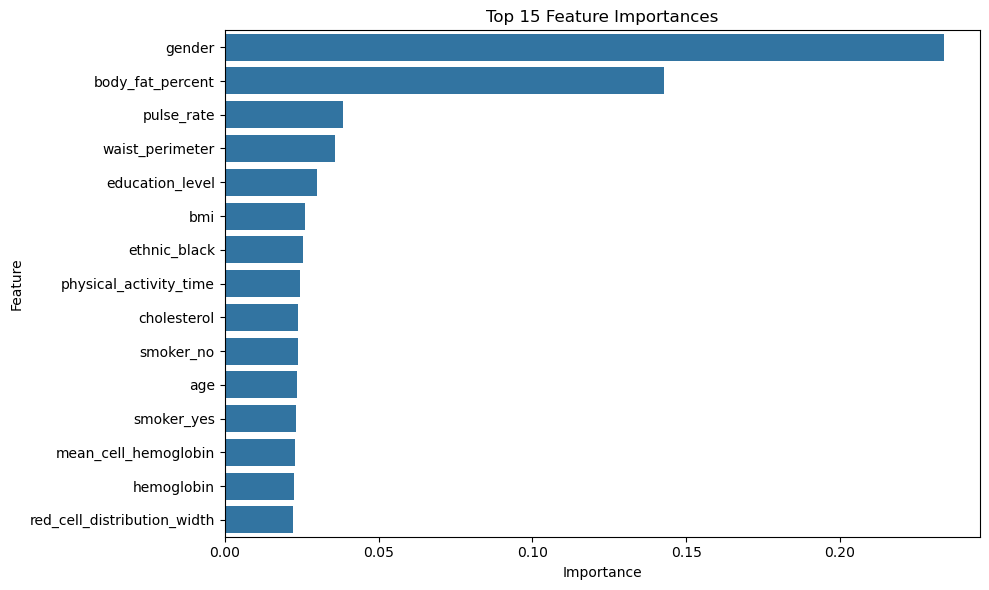

In [42]:
# Importancia de cada predictor
importances = xgb_best.feature_importances_
features = X.columns

# Mostrar en orden descendente
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title("Top 15 Feature Importances")
plt.tight_layout()
#plt.savefig("importance.png", dpi = 600)
plt.show()

-------------------------
<a id = saving><a/>

[Go to index](#id_0)

# 5. Saving the Best Model

In [43]:
import joblib

In [45]:
joblib.dump(xgb_best, "../app/xgb_model.joblib")
print("XGBoost model saved to app/xgb_model.joblib")

XGBoost model saved to app/xgb_model.joblib


In [65]:
scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler, "../app/scaler.joblib")

['../app/scaler.joblib']